In [56]:
!pip install seaborn
!pip install sklearn
!pip install optuna

In [57]:
#imports
import pandas as pd
import numpy as np
import seaborn as sns
sns.set()

In [58]:
import os
import config
from pathlib import Path
data_source = os.path.join(os.path.dirname(os.getcwd()), os.path.join(Path(config.DATA_DIR), config.FILE_NAME))
data_source

'C:\\toolbox\\ML OPS\\End_To_End_Model_Deployment_MLOps\\data\\credit_card_transactions.csv'

# Data Preparation

In [59]:
data = pd.read_csv(data_source)

data = data.drop(['Unnamed: 0'], axis = 1, inplace = False)

data.head()

,customer_id,Time,V1,V2,V3,V4,V5,Amount,Class,created_time
0,0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,149.62,0,2020-09-07
1,1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,2.69,0,2020-11-22
2,2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,378.66,0,2020-10-02
3,3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,123.50,0,2020-09-06
4,4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,69.99,0,2020-07-12


In [60]:
data.shape

(284807, 10)

In [61]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 10 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   customer_id   284807 non-null  int64  
 1   Time          284807 non-null  float64
 2   V1            284807 non-null  float64
 3   V2            284807 non-null  float64
 4   V3            284807 non-null  float64
 5   V4            284807 non-null  float64
 6   V5            284807 non-null  float64
 7   Amount        284807 non-null  float64
 8   Class         284807 non-null  int64  
 9   created_time  284807 non-null  object 
dtypes: float64(7), int64(2), object(1)
memory usage: 21.7+ MB


In [62]:
X = data.drop(['customer_id', 'Class', 'created_time'], axis=1, inplace=False)

y = data[['Class']]  

In [63]:
print(X.info())

print(y.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 7 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   Amount  284807 non-null  float64
dtypes: float64(7)
memory usage: 15.2 MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 1 columns):
 #   Column  Non-Null Count   Dtype
---  ------  --------------   -----
 0   Class   284807 non-null  int64
dtypes: int64(1)
memory usage: 2.2 MB
None


# Visualisation

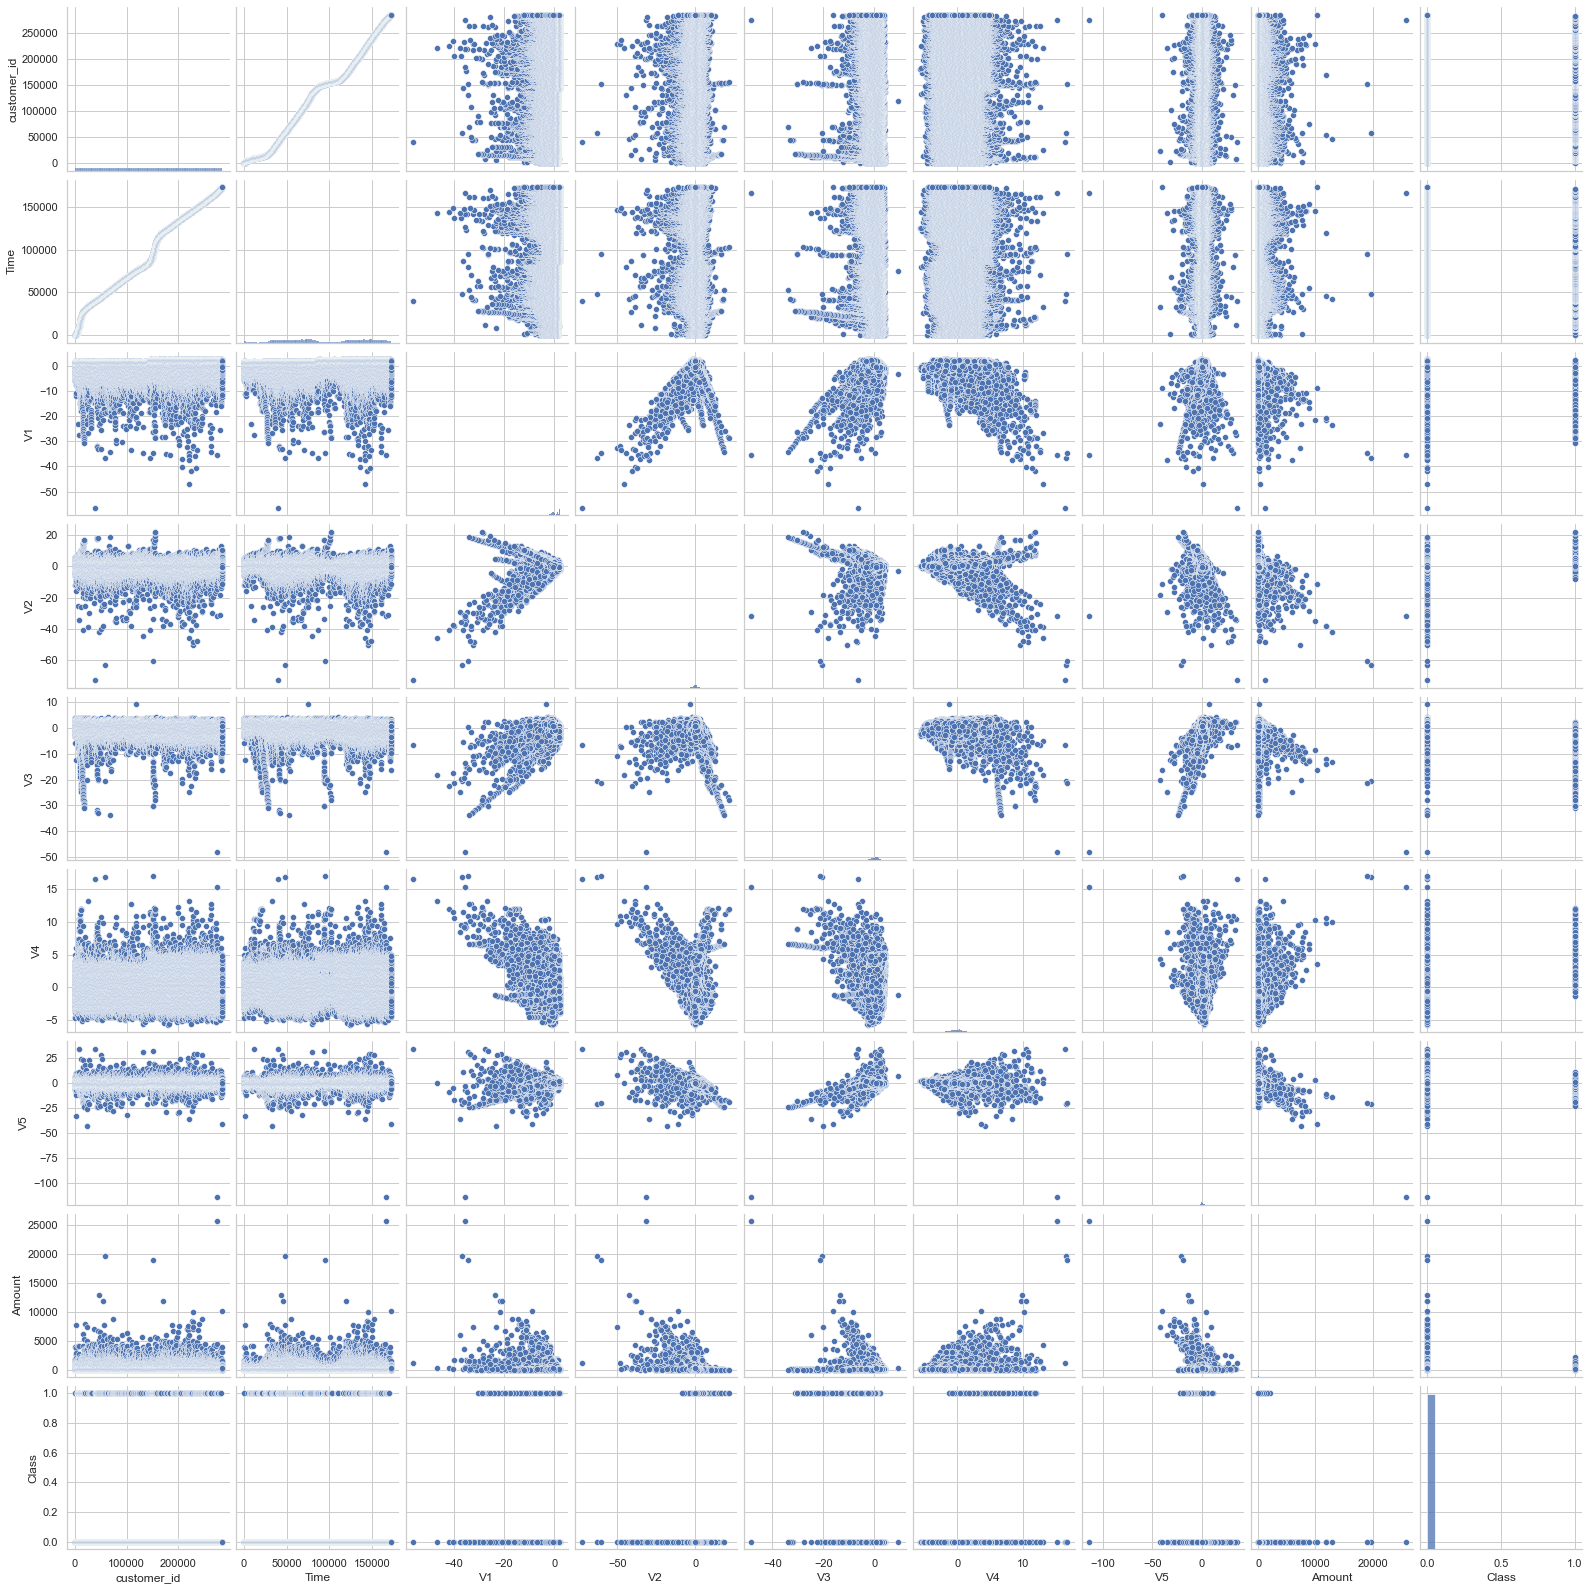

In [79]:
#Lets visualise the graph

sns.set_style('whitegrid')

sns.pairplot(data)

# Training

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import  Pipeline
from sklearn.metrics import r2_score,mean_absolute_error,mean_squared_error,accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=5)

pipeline = Pipeline([
                     ('scalar', StandardScaler()),
                      ('clf', RandomForestClassifier())])

pipeline.fit(X_train, y_train)
print("test score is",pipeline.score(X_test, y_test))
print("train score is", pipeline.score(X_train, y_train))


C:\Users\asokk\.conda\envs\mlops\lib\site-packages\sklearn\pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


test score is 0.9991397773954567
train score is 1.0


# Optimization

In [70]:
from sklearn.model_selection import cross_val_score
import joblib

# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
print(max_depth)
def objective(trial):    
    
    joblib.dump(study, 'study.pkl')
    
    clf__n_estimators = trial.suggest_categorical('clf__n_estimators', [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)])
    clf__min_samples_split = trial.suggest_int('clf__min_samples_split', 2, 5, 10)    
    clf__min_samples_leaf = trial.suggest_int('clf__min_samples_leaf', 1, 2, 4)    
    clf__bootstrap = trial.suggest_categorical('clf__bootstrap', [False, True])  
    clf__max_features = trial.suggest_categorical('clf__max_features', ['auto', 'sqrt']) 
    clf__max_depth = trial.suggest_categorical('clf__max_depth', max_depth) 
    

    params = {
        'clf__n_estimators': clf__n_estimators,
        'clf__min_samples_split': clf__min_samples_split,
        'clf__min_samples_leaf': clf__min_samples_leaf,
        'clf__bootstrap': clf__bootstrap,
        'clf__max_features': clf__max_features,
        'clf__max_depth': clf__max_depth,
    }
    
    pipeline.set_params(**params)

    return - np.mean(cross_val_score(pipeline, X, y, cv=8, n_jobs=-1))

[10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None]


In [71]:
import optuna

study = optuna.create_study()
study.optimize(objective, timeout=3600)

[I 2021-07-29 18:48:19,489] A new study created in memory with name: no-name-f926c564-2ce4-4e00-8820-43044e24c0bd
C:\Users\asokk\.conda\envs\mlops\lib\site-packages\optuna\distributions.py:560: UserWarning: The distribution is specified by [2, 5] and step=10, but the range is not divisible by `step`. It will be replaced by [2, 2].
  warnings.warn(
C:\Users\asokk\.conda\envs\mlops\lib\site-packages\optuna\distributions.py:560: UserWarning: The distribution is specified by [1, 2] and step=4, but the range is not divisible by `step`. It will be replaced by [1, 1].
  warnings.warn(
[I 2021-07-29 19:19:07,165] Trial 0 finished with value: -0.8784619776571735 and parameters: {'clf__n_estimators': 1000, 'clf__min_samples_split': 2, 'clf__min_samples_leaf': 1, 'clf__bootstrap': False, 'clf__max_features': 'auto', 'clf__max_depth': None}. Best is trial 0 with value: -0.8784619776571735.
C:\Users\asokk\.conda\envs\mlops\lib\site-packages\optuna\distributions.py:560: UserWarning: The distribution

In [72]:
print('best_value:', study.best_value)

best_value: -0.8784619776571735


In [75]:
print('best_params', study.best_params)

{'clf__n_estimators': 1000,
 'clf__min_samples_split': 2,
 'clf__min_samples_leaf': 1,
 'clf__bootstrap': False,
 'clf__max_features': 'auto',
 'clf__max_depth': None}

In [78]:
study.best_trial

FrozenTrial(number=0, values=[-0.8784619776571735], datetime_start=datetime.datetime(2021, 7, 29, 18, 48, 19, 491035), datetime_complete=datetime.datetime(2021, 7, 29, 19, 19, 7, 165657), params={'clf__n_estimators': 1000, 'clf__min_samples_split': 2, 'clf__min_samples_leaf': 1, 'clf__bootstrap': False, 'clf__max_features': 'auto', 'clf__max_depth': None}, distributions={'clf__n_estimators': CategoricalDistribution(choices=(200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000)), 'clf__min_samples_split': IntUniformDistribution(high=2, low=2, step=10), 'clf__min_samples_leaf': IntUniformDistribution(high=1, low=1, step=4), 'clf__bootstrap': CategoricalDistribution(choices=(False, True)), 'clf__max_features': CategoricalDistribution(choices=('auto', 'sqrt')), 'clf__max_depth': CategoricalDistribution(choices=(10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None))}, user_attrs={}, system_attrs={}, intermediate_values={}, trial_id=0, state=TrialState.COMPLETE, value=None)

In [73]:
pipeline.set_params(**study.best_params)
pipeline.fit(X, y)
print("test score is",pipeline.score(X_test, y_test))
print("train score is", pipeline.score(X_train, y_train))

C:\Users\asokk\.conda\envs\mlops\lib\site-packages\sklearn\pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


test score is 1.0
train score is 1.0


# Evaluation

ROC AUC Score: 0.9442304140950329


Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     56858
           1       0.95      0.56      0.70       104

    accuracy                           1.00     56962
   macro avg       0.98      0.78      0.85     56962
weighted avg       1.00      1.00      1.00     56962

Confusion matrix:
 [[56855     3]
 [   46    58]]


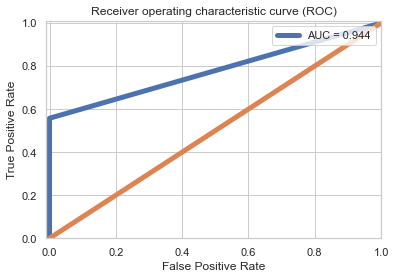

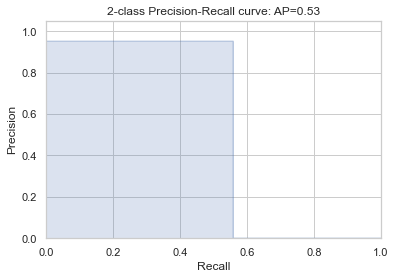

In [38]:
from sklearn.metrics import roc_curve,roc_auc_score, precision_recall_curve, average_precision_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

# Obtain model predictions
y_predicted = pipeline.predict(X_test)

# Create true and false positive rates
false_positive_rate, true_positive_rate, threshold = roc_curve(y_test, y_predicted)

# Calculate Area Under the Receiver Operating Characteristic Curve 
probs = pipeline.predict_proba(X_test)
roc_auc = roc_auc_score(y_test, probs[:, 1])
print('ROC AUC Score:',roc_auc)
print('\n')

# Obtain precision and recall 
precision, recall, thresholds = precision_recall_curve(y_test, y_predicted)

# Calculate average precision 
average_precision = average_precision_score(y_test, y_predicted)

# Define a roc_curve function
def plot_roc_curve(false_positive_rate,true_positive_rate,roc_auc):
    plt.plot(false_positive_rate, true_positive_rate, linewidth=5, label='AUC = %0.3f'% roc_auc)
    plt.plot([0,1],[0,1], linewidth=5)
    plt.xlim([-0.01, 1])
    plt.ylim([0, 1.01])
    plt.legend(loc='upper right')
    plt.title('Receiver operating characteristic curve (ROC)')
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

# Define a precision_recall_curve function
def plot_pr_curve(recall, precision, average_precision):
    plt.step(recall, precision, color='b', alpha=0.2, where='post')
    plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(average_precision))
    plt.show()

# Print the classifcation report and confusion matrix
print('Classification report:\n', classification_report(y_test, y_predicted))
print('Confusion matrix:\n',confusion_matrix(y_true = y_test, y_pred = y_predicted))

# Plot the roc curve 
plot_roc_curve(false_positive_rate,true_positive_rate,roc_auc)

# Plot recall precision curve
plot_pr_curve(recall, precision, average_precision)

In [82]:
import pickle
model_path = os.path.join(os.path.dirname(os.getcwd()), config.MODEL_DIR)
model_path

'C:\\toolbox\\ML OPS\\End_To_End_Model_Deployment_MLOps\\model'

In [83]:

with open(model_path + "\\fradulant_transaction_model.pickle", "wb") as f:
    pickle.dump(pipeline, f)